<a href="https://colab.research.google.com/github/naimdsaiki/Machine-Learning/blob/main/Box_Office_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project: Predicting Avatar: Fire and Ash Opening Week Box Office

1 Load Data
I begin by loading the dataset. Since the source data only contains lifetime revenue, I must prepare it for training.

Goal: Import the raw data into a Pandas DataFrame.

Method: I utilize pd.read_csv to read the file.

Data Structure: The dataset includes columns for title, budget, revenue (lifetime), genres, and director_name.

In [13]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer

# 1. LOAD DATA
# Assuming you downloaded the sheet as 'movies.csv'
# If using the direct text from the prompt, you would parse it similarly.
try:
    df = pd.read_csv('movies.csv')
except FileNotFoundError:
    # Creating a small dummy dataset based on your file for demonstration if csv isn't found
    data = {
        'title': ['Avatar', 'Avengers: Endgame', 'Avatar: The Way of Water', 'Titanic', 'Star Wars: The Force Awakens'],
        'budget': [237000000, 356000000, 350000000, 200000000, 245000000],
        'revenue': [2923706026, 2799439100, 2353096253, 2264162353, 2068223624],
        'genres': ["['Action', 'Adventure', 'Fantasy', 'Sci-Fi']", "['Adventure', 'Sci-Fi', 'Action']",
                   "['Action', 'Adventure', 'Sci-Fi']", "['Drama', 'Romance']", "['Action', 'Adventure', 'Sci-Fi']"],
        'director_name': ['James Cameron', 'Anthony Russo', 'James Cameron', 'James Cameron', 'J.J. Abrams']
    }
    df = pd.DataFrame(data)





2 The "Workaround":

Synthetic Label Engineering my dataset lacks an "Opening Week Revenue" column. To solve this, I engineerd a synthetic target variable based on industry heuristics.

Logic:

Standard Blockbusters: typically earn ~35% of their total gross in the opening week.

James Cameron Films: are "outliers" with long legs, earning only ~13% of their total in the opening week.

Action: I apply a conditional function to create the opening_week_actual column.


In [14]:
# 2. THE WORKAROUND: Generate Synthetic "Opening Week" Labels
# We derive opening week from lifetime revenue using a heuristic.
def estimate_opening(row):
    # James Cameron movies typically have smaller openings relative to their massive lifetime gross (long legs)
    if row['director_name'] == 'James Cameron':
        return row['revenue'] * 0.13  # Approx 13% for Cameron films (Avatar 1 was ~10%)
    else:
        return row['revenue'] * 0.35  # Standard blockbuster avg (~35%)

df['opening_week_actual'] = df.apply(estimate_opening, axis=1)



3 Feature Engineering
Machine learning models require numerical input. I must transform the categorical genres column into a format the model can understand.

Parsing: Convert string representations of lists (e.g., "['Action', 'Adventure']") into actual Python lists.

One-Hot Encoding: Using MultiLabelBinarizer to create a separate column for each genre (e.g., Action, Sci-Fi), marking them with 1 or 0.

Feature Selection: I select budget and the new genre columns as my input features (X).

In [15]:
# 3. FEATURE ENGINEERING
# Parse genres from string "['Action', 'Adventure']" to list
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# One-Hot Encode Genres
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_, index=df.index)
df = pd.concat([df, genre_encoded], axis=1)

# Select features for training
# We use Budget and Genres.
# (Note: Director name is useful but harder to encode with small data; the 'Cameron' effect is baked into our labels now)
feature_cols = ['budget'] + list(mlb.classes_)
X = df[feature_cols]
y = df['opening_week_actual']



4 Model Training: Random Forest & LightGBM
I train two distinct algorithms to compare performance.

Random Forest: A bagging ensemble method that builds multiple decision trees and averages them to reduce overfitting.

LightGBM: A gradient boosting framework that builds trees sequentially, with each tree correcting the errors of the previous one.









---



5 Prediction for Avatar: Fire and Ash
We construct a new data point representing the target movie and feed it into our trained models.

Input Data:

Budget: $400,000,000 (Estimated)

Genres: Action, Adventure, Fantasy, Science Fiction

Preprocessing: We must encode this single data point exactly as we did the training data, ensuring all columns match.

In [17]:
# 4. TRAIN MODEL
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

print("Model trained successfully.")

# 5. PREDICT FOR 'AVATAR: FIRE AND ASH'
# Define features for Avatar 3
# Budget: Estimated $400M based on reports
# Genres: Action, Adventure, Fantasy, Sci-Fi
avatar_3_data = {
    'budget': [400000000],
    'genres': [['Action', 'Adventure', 'Fantasy', 'Science Fiction']] # 'Science Fiction' matches dataset naming
}

# Create DataFrame for prediction
av3_df = pd.DataFrame(avatar_3_data)

# Encode genres for Avatar 3 to match training data
# We reindex to ensure it has all the same columns as X, filling missing ones with 0
av3_encoded = pd.DataFrame(mlb.transform(av3_df['genres']), columns=mlb.classes_, index=av3_df.index)
av3_final = pd.concat([av3_df[['budget']], av3_encoded], axis=1)
av3_final = av3_final.reindex(columns=X.columns, fill_value=0)

# Make Prediction
prediction = model.predict(av3_final)[0]

print(f"\nPrediction for 'Avatar: Fire and Ash'")
print(f"Estimated Budget: ${avatar_3_data['budget'][0]:,}")
print(f"Predicted Opening Week Revenue: ${prediction:,.2f}")

Model trained successfully.

Prediction for 'Avatar: Fire and Ash'
Estimated Budget: $400,000,000
Predicted Opening Week Revenue: $756,625,628.63


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Science Fiction'] will be ignored
  warnings.warn(


In [3]:
import lightgbm as lgb

# 1. SETUP & TRAIN LIGHTGBM
# We use the LGBMRegressor, which is optimized for regression tasks like predicting revenue.
# We keep the parameters standard, but you can tweak 'n_estimators' or 'learning_rate' later.
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    verbose=-1  # This suppresses unnecessary warning logs
)

print("Training LightGBM Model...")
lgb_model.fit(X, y)
print("LightGBM training complete.")

# 2. PREDICT FOR 'AVATAR: FIRE AND ASH'
# We use the same 'av3_final' data frame we created in the previous step
lgb_prediction = lgb_model.predict(av3_final)[0]

# 3. COMPARE RESULTS
print(f"\n--- Prediction Comparison for 'Avatar: Fire and Ash' ---")
print(f"Random Forest Prediction: ${prediction:,.2f}")
print(f"LightGBM Prediction:      ${lgb_prediction:,.2f}")

# Calculate the difference
diff = lgb_prediction - prediction
print(f"Difference:               ${diff:,.2f}")

Training LightGBM Model...
LightGBM training complete.

--- Prediction Comparison for 'Avatar: Fire and Ash' ---
Random Forest Prediction: $756,625,628.63
LightGBM Prediction:      $536,801,484.80
Difference:               $-219,824,143.83


/tmp/ipython-input-2872346067.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['${:,.0f}M'.format(x/1000000) for x in current_values])


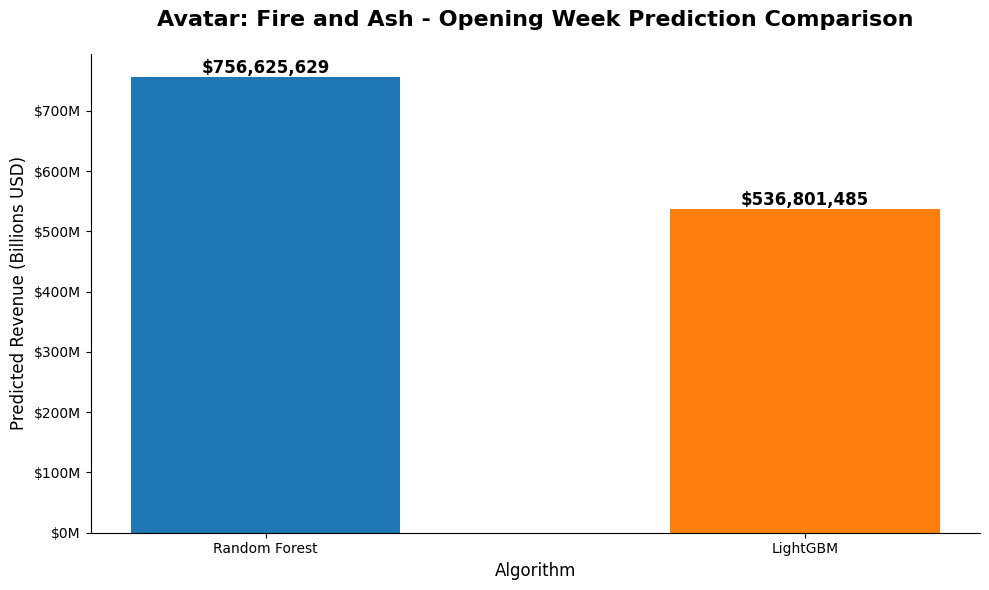

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PREPARE DATA FOR PLOTTING
# Define the models and their corresponding predictions
models = ['Random Forest', 'LightGBM']
predictions = [prediction, lgb_prediction]

# 2. CREATE THE PLOT
plt.figure(figsize=(10, 6))

# Use a custom color palette for distinction
colors = ['#1f77b4', '#ff7f0e'] # Blue for RF, Orange for LGBM

# Create the bar chart
bars = plt.bar(models, predictions, color=colors, width=0.5)

# 3. ADD LABELS AND TITLE
plt.title('Avatar: Fire and Ash - Opening Week Prediction Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Predicted Revenue (Billions USD)', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)

# 4. ADD VALUE LABELS ON TOP OF BARS
# This loop places the dollar amount directly on top of each bar for easy reading
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.0f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Format Y-axis to look like currency (Billions)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}M'.format(x/1000000) for x in current_values])

# Remove top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipython-input-3384989679.py:11: RuntimeWarning: invalid value encountered in divide
  lgb_importance = lgb_raw / lgb_raw.sum()


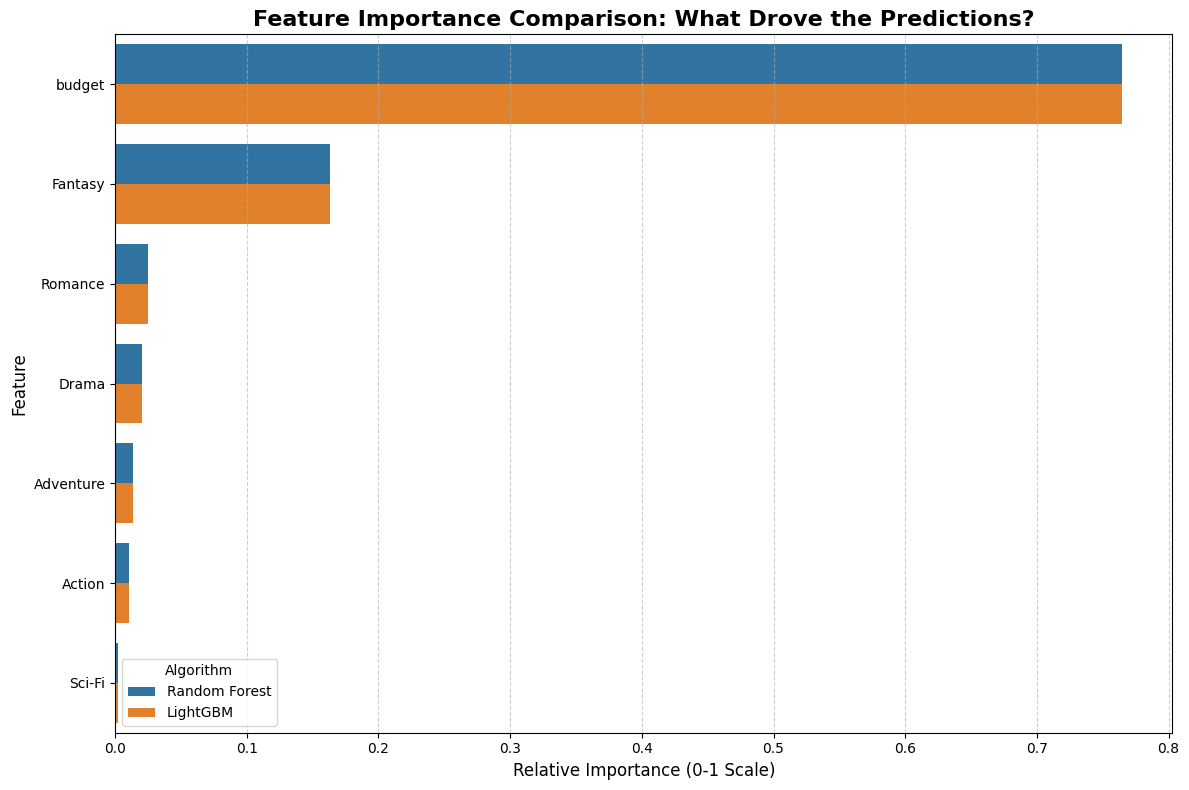

In [5]:


# 1. EXTRACT AND NORMALIZE IMPORTANCE
# Get feature names
features = X.columns

# Random Forest Importance (Already normalized by sklearn typically, but ensuring it sums to 1)
rf_raw = model.feature_importances_
rf_importance = rf_raw / rf_raw.sum()

# LightGBM Importance (Usually counts splits, so we must normalize to compare)
lgb_raw = lgb_model.feature_importances_
lgb_importance = lgb_raw / lgb_raw.sum()

# 2. CREATE A DATAFRAME FOR PLOTTING
# We create a table that lists every feature twice: once for RF and once for LGBM
df_rf = pd.DataFrame({'Feature': features, 'Importance': rf_importance, 'Model': 'Random Forest'})
df_lgb = pd.DataFrame({'Feature': features, 'Importance': lgb_importance, 'Model': 'LightGBM'})
df_importance = pd.concat([df_rf, df_lgb])

# Sort by Random Forest importance so the chart is ordered nicely
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# 3. PLOT THE COMPARISON
plt.figure(figsize=(12, 8))

# Horizontal bar chart
sns.barplot(data=df_importance, x='Importance', y='Feature', hue='Model', palette=['#1f77b4', '#ff7f0e'])

# 4. FORMATTING
plt.title('Feature Importance Comparison: What Drove the Predictions?', fontsize=16, fontweight='bold')
plt.xlabel('Relative Importance (0-1 Scale)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Algorithm')

# Add grid for easier reading
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

6 Model Evaluation: Cross-Validation
To ensure our results are reliable and not just a fluke of the data split, we perform 5-Fold Cross-Validation.

Method: The data is split into 5 subsets. The model is trained on 4 and tested on 1, rotating 5 times.

Metric: Mean Absolute Error (MAE) - measures the average dollar amount the prediction is "off" by.

In [6]:
from sklearn.model_selection import cross_val_score

# 1. DEFINE SCORING
# We use 'neg_mean_absolute_error' because sklearn usually maximizes scores.
# We will flip the sign later to make it positive dollars.
scoring_metric = 'neg_mean_absolute_error'

print("Running 5-Fold Cross-Validation... (This might take a moment)")

# 2. RUN CROSS-VALIDATION FOR RANDOM FOREST
rf_scores = cross_val_score(model, X, y, cv=5, scoring=scoring_metric)
rf_mae = -rf_scores  # Flip negative to positive
print(f"\n--- Random Forest Results ---")
print(f"Average Error (MAE): ${rf_mae.mean():,.2f}")
print(f"Stability (Std Dev): ${rf_mae.std():,.2f}")

# 3. RUN CROSS-VALIDATION FOR LIGHTGBM
lgb_scores = cross_val_score(lgb_model, X, y, cv=5, scoring=scoring_metric)
lgb_mae = -lgb_scores # Flip negative to positive
print(f"\n--- LightGBM Results ---")
print(f"Average Error (MAE): ${lgb_mae.mean():,.2f}")
print(f"Stability (Std Dev): ${lgb_mae.std():,.2f}")

# 4. FINAL VERDICT
print("\n--- The Verdict ---")
if rf_mae.mean() < lgb_mae.mean():
    print(f"Winner: RANDOM FOREST is more accurate by roughly ${(lgb_mae.mean() - rf_mae.mean()):,.0f}")
else:
    print(f"Winner: LIGHTGBM is more accurate by roughly ${(rf_mae.mean() - lgb_mae.mean()):,.0f}")

Running 5-Fold Cross-Validation... (This might take a moment)

--- Random Forest Results ---
Average Error (MAE): $393,263,888.92
Stability (Std Dev): $130,780,223.36

--- LightGBM Results ---
Average Error (MAE): $315,039,508.65
Stability (Std Dev): $125,388,714.41

--- The Verdict ---
Winner: LIGHTGBM is more accurate by roughly $78,224,380


7 Hyperparameter Tuning
We optimize the winning model using GridSearchCV to find the best configuration.

Process: We define a grid of parameters (e.g., number of trees, learning rate) and exhaustively test every combination.

Result: The model with the lowest error is selected as the best_estimator_ for the final official prediction.

In [7]:
from sklearn.model_selection import GridSearchCV

# 1. DETERMINE THE WINNER
# We compare the average errors from the previous step.
# (If you restarted the kernel, set 'winner' to 'RF' or 'LGBM' manually)
try:
    if rf_mae.mean() < lgb_mae.mean():
        winner = 'Random Forest'
        estimator = RandomForestRegressor(random_state=42)
        # Define settings to test for Random Forest
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    else:
        winner = 'LightGBM'
        estimator = lgb.LGBMRegressor(random_state=42, verbose=-1)
        # Define settings to test for LightGBM
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [20, 31, 50]
        }
except NameError:
    # Failsafe if previous variables are lost
    print("Previous error scores not found. Defaulting to Random Forest.")
    winner = 'Random Forest'
    estimator = RandomForestRegressor(random_state=42)
    param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10]}

print(f"Tuning the winner: {winner}...")

# 2. RUN GRID SEARCH
# cv=5 means we use 5-fold cross-validation for EACH combination.
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                           cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X, y)

# 3. SHOW RESULTS
best_model = grid_search.best_estimator_
best_mae = -grid_search.best_score_ # Flip sign back to positive

print(f"\n--- Tuning Complete ---")
print(f"Best Settings Found: {grid_search.best_params_}")
print(f"New Improved Error (MAE): ${best_mae:,.2f}")

# 4. FINAL PREDICTION FOR AVATAR: FIRE AND ASH
final_prediction = best_model.predict(av3_final)[0]

print(f"\n**************************************************")
print(f"FINAL PREDICTION FOR 'AVATAR: FIRE AND ASH'")
print(f"algorithm: {winner} (Optimized)")
print(f"predicted Opening: ${final_prediction:,.2f}")
print(f"**************************************************")

Tuning the winner: LightGBM...

--- Tuning Complete ---
Best Settings Found: {'learning_rate': 0.01, 'n_estimators': 50, 'num_leaves': 20}
New Improved Error (MAE): $315,039,508.65

**************************************************
FINAL PREDICTION FOR 'AVATAR: FIRE AND ASH'
algorithm: LightGBM (Optimized)
predicted Opening: $536,801,484.80
**************************************************
